# Visualization with Bitbrains Data 

# Data Science Consulting Project with [Manifold.co](manifold.co)

### Modeling System Resource Usage for Predictive Scheduling

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import read_csv, datetime
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LassoCV, RidgeCV
from itertools import product                    
from tqdm import tqdm_notebook
%matplotlib inline

import warnings                                
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read in data

In [2]:
path = r'rnd/2013-7/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)

concatenated_df   = pd.concat(df_from_each_file)

In [3]:
path = r'rnd/2013-8/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df8   = pd.concat(df_from_each_file)

In [4]:
path = r'rnd/2013-9/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df9   = pd.concat(df_from_each_file)

## Create Data Frame

In [5]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

Check it out

In [6]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1372629804,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667,1
1,1372630104,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000,1
2,1372630404,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667,1
3,1372630704,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000,1
4,1372631004,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,1.000000,1


## Feature engineering and converting pandas into a timeseries
### Timestamp is in UNIX epochs

In [7]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')

# Date Feature Engineering
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)

# Other Feature Engineering
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]
concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

## Fill in missing values using forward propagating function from pandas

In [8]:
concatenated_df = concatenated_df.fillna(method='ffill')

## Create new data frame: resampled & aggregated over each hour for all VMs

In [9]:
hourlydat = concatenated_df.resample('H').sum()

## Examine autocorrelations of hourly CPU usage

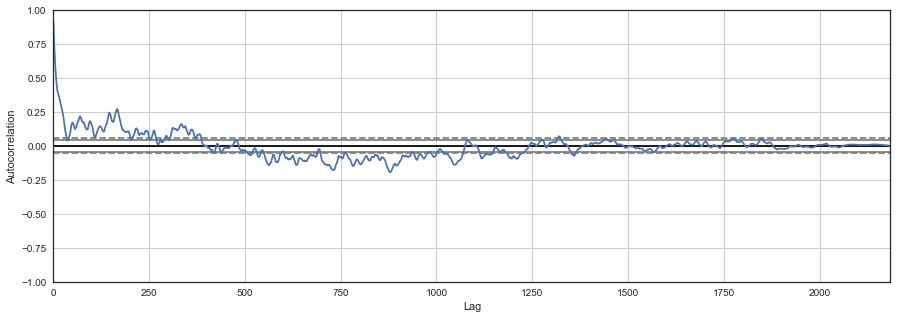

In [265]:
## Hourly resampled means
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(hourlydat['CPU usage [MHZ]']);

## Is CPU Capacity Ever Met? If so, how often?

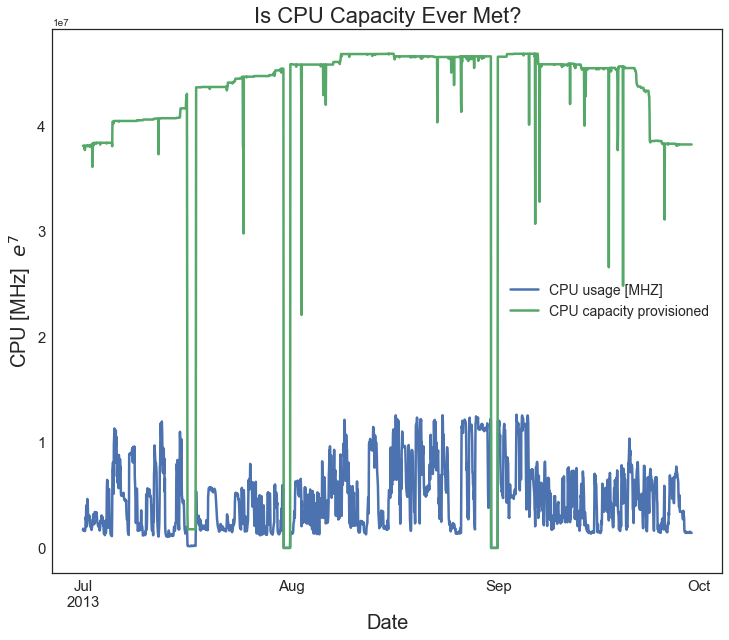

In [237]:
overprovision = pd.DataFrame(hourlydat['CPU usage [MHZ]'])
overprovision['CPU capacity provisioned'] = pd.DataFrame(hourlydat['CPU capacity provisioned [MHZ]'])

plt.style.use('seaborn-white')
overprovision.plot(figsize = (12,10),linewidth=2.5, fontsize=20)
plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.savefig('CPU_cap_under.png')
plt.show()

In [ ]:
## percent CPU used across network

In [190]:
print("The Average CPU Percent Usage is only: " + str(round(concatenated_df['CPU usage [%]'].mean(),2)) + "%!!")
print("The Minimum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].min(),2)) + "%!!")
print("The Maximum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].max(),2)) + "%, possibly inidcating the system crashed?")

The Average CPU Percent Usage is only: 6.01%!!
The Minimum CPU Percent Usage is: 0.0%!!
The Maximum CPU Percent Usage is: 182.13%, possibly inidcating the system crashed?


## What might cause over provision? Spikes in Network throughput? 

### Graphs below are aggregated (summed)

In [ ]:
cpu = concatenated_df[['CPU usage [MHZ]']]
receive = concatenated_df[['Network received throughput [KB/s]']]
transmit = concatenated_df[['Network transmitted throughput [KB/s]']]
provisioned = concatenated_df[['CPU capacity provisioned [MHZ]']]

hourlycpu = cpu.resample('H').sum()
hourlytransmit = transmit.resample('H').sum()
hourlyreceive = receive.resample('H').sum()
hourlyprovisioned = provisioned.resample('H').sum()

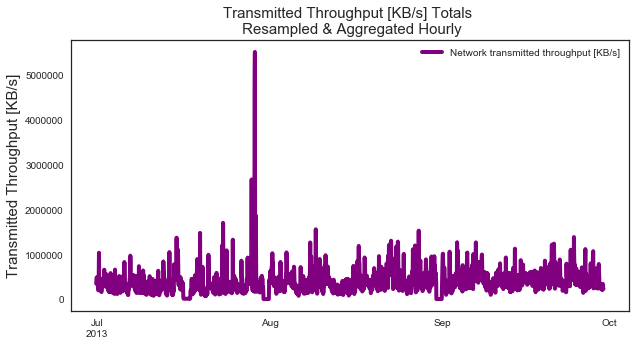

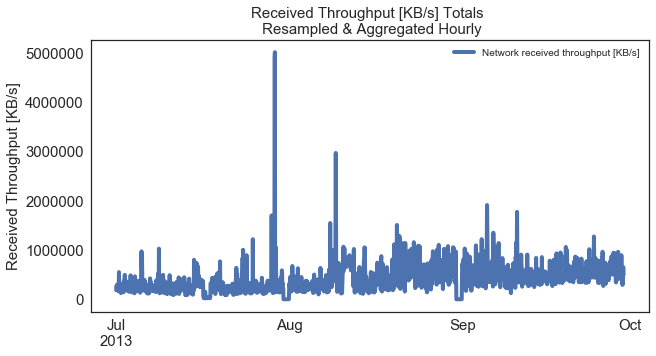

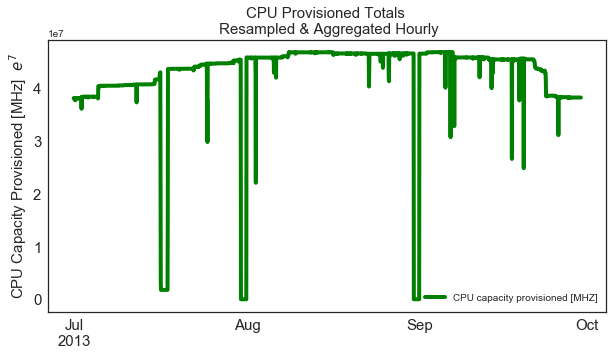

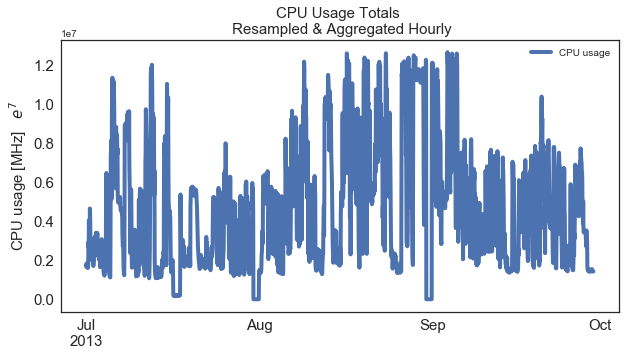

In [188]:
hourlytransmit.plot(color = "purple",linewidth = 4,  figsize=(10, 5))
plt.title('Transmitted Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);

hourlyreceive.plot( linewidth = 4, figsize=(10, 5))
plt.title('Received Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlyprov.plot(color = "g", linewidth = 4, figsize=(10, 5))
plt.title('CPU Provisioned Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]  $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlycpu.plot(linewidth = 4, figsize=(10, 5))
plt.title('CPU Usage Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

### Graphs below are max values across network

In [ ]:
hourlycpu = cpu.resample('H').max()
hourlytransmit = transmit.resample('H').max()
hourlyreceive = receive.resample('H').max()
hourlyprovisioned = provisioned.resample('H').max()

In [ ]:
hourlytransmit.plot(color = "purple",linewidth = 4,  figsize=(10, 5))
plt.title('Transmitted Throughput [KB/s] Max',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);

hourlyreceive.plot( linewidth = 4, figsize=(10, 5))
plt.title('Received Throughput [KB/s] Max',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlyprovisioned.plot(color = "g", linewidth = 4, figsize=(10, 5))
plt.title('CPU Provisioned Max',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]  $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlycpu.plot(linewidth = 4, figsize=(10, 5))
plt.title('CPU Usage Max',fontsize=15);
plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

## Visualize rolling mean trends over time, large spike, keep in model

In [ ]:
df_rm = pd.concat([receive.rolling(12).mean(), transmit.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(15,5), linewidth=2, fontsize=20)
plt.xlabel('Date', fontsize=20);

In [ ]:
df_rm = pd.concat([cpu.rolling(24).sum()], axis=1)
df_rm.plot(figsize=(15,5), linewidth=2, fontsize=20)
plt.xlabel('Date', fontsize=20);

## Zoom in to look at hourly trends in cpu usage

In [ ]:
hourlycpu[60:120].plot(style=[':', '--', '-'])
plt.ylabel('CPU Usage Avg [MHZ]');

## Plots of CPU Usage Across the Week- Highly Variable!

In [16]:
hourlydat = concatenated_df.resample('H').sum()
hourlydat['Date_Time'] = hourlydat.index
hourlydat['weekday'] = hourlydat['Date_Time'].dt.dayofweek
hourlydat['weekend'] = ((hourlydat.weekday) // 5 == 1).astype(float)

### Feature engineering with the date

In [17]:
hourlydat['month']=hourlydat['Date_Time'].dt.month 
hourlydat['day']=hourlydat['Date_Time'].dt.day
hourlydat.drop('Date_Time', axis=1, inplace=True)
hourlydat.drop('Timestamp [ms]', axis=1, inplace=True)

In [18]:
plotdays = hourlydat.groupby('weekday').agg({'CPU usage [MHZ]': ['mean']})
plotdays = pd.DataFrame(plotdays)

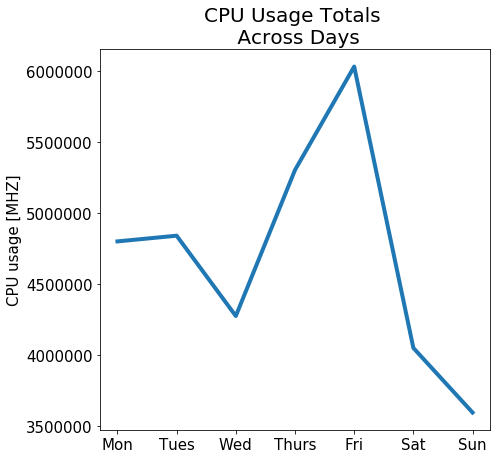

In [19]:
plotdays.plot(linewidth = 4, figsize=(7, 7),legend=None)
plt.title('CPU Usage Totals \n Across Days',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=15);
plt.yticks(fontsize=15);

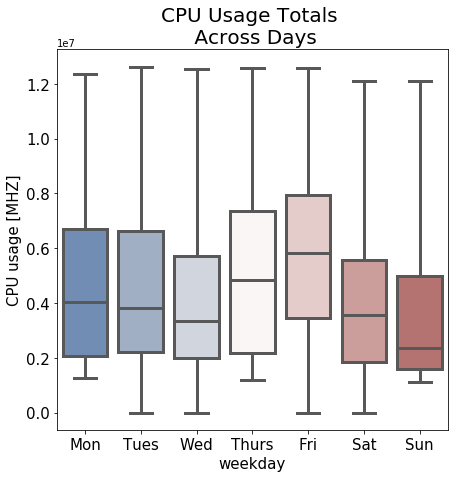

In [20]:
plt.figure(figsize=(7,7))
plt.title('CPU Usage Totals \n Across Days',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('', fontsize=15);
sns.boxplot(y=hourlydat['CPU usage [MHZ]'],x = hourlydat.weekday,
            whis=np.inf, palette="vlag",linewidth=3)
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=15);

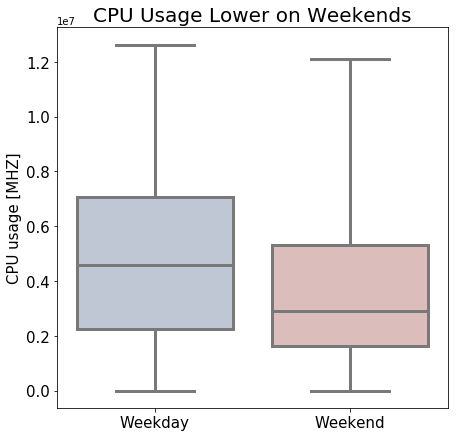

In [22]:
plt.figure(figsize=(7,7))
plt.title('CPU Usage Lower on Weekends',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.yticks(fontsize=15);
sns.boxplot(y=hourlydat['CPU usage [MHZ]'],x = hourlydat.weekend,
            whis=np.inf, palette="vlag",linewidth=3)
plt.xticks(np.arange(2), ('Weekday', 'Weekend'), fontsize=15);
plt.xlabel('', fontsize=15);


## Visualize Correlations in Data (hourlydat)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(hourlydat.corr())